# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [4]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2023-02-10 15:07:04--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2023-02-10 15:07:04 (28.7 MB/s) - ‘tiny_img.py’ saved [813/813]

--2023-02-10 15:07:05--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response

In [5]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was already downloaded to './tiny-imagenet-200.zip'. Skip downloading
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [6]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt
import numpy as np

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

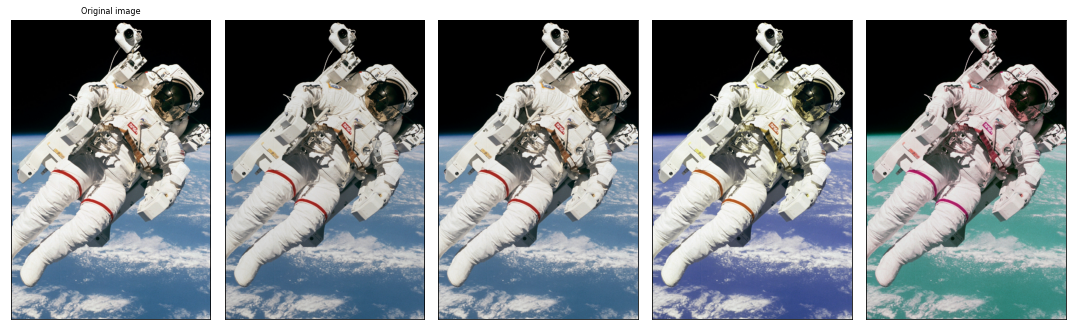

In [36]:
jitter = transforms.ColorJitter(brightness=.1, hue=.1, saturation=0.1)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot_for_augment(jitted_imgs)

In [7]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.35),
     transforms.ToTensor(),
     transforms.RandomRotation(degrees=5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(brightness=.1, hue=.1, saturation=0.1)
     # you may add any other transforms here
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [8]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [9]:
from torch.utils.data import Dataset
import os
from PIL import Image
import cv2

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        
        self.classes = []
        for _, temp_class in annotations:
            if temp_class not in self.classes:
                self.classes.append(temp_class)
        self.classes.sort()
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = np.array(Image.open(img_name), dtype = np.float32) / 255.
            if image.shape != (64, 64, 3):
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(image)
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        target = self.targets[index]
        image = self.transform(image)
        target =  torch.as_tensor(target)

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [10]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:03<00:00, 2687.61it/s]


For the most cases the default `DataLoader` will be good enough.

In [11]:
#!L
batch_size = 128
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=2)

In [12]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=2)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [13]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [14]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(f"conv_block_{block_index}_{layer_index_in_block}", 
                             ConvBNRelu(in_channels, out_channels, kernel_size=3))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [15]:
model = create_vgg_like_network()
model = model.to(device)
model

Sequential(
  (conv_block_0_0): ConvBNRelu(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_block_0_1): ConvBNRelu(
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (mp_0): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block_1_0): ConvBNRelu(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_block_1_1): ConvBNRelu(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (mp_1): MaxPool2d(

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [15]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [17]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [16]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            y_batch = torch.as_tensor(y_batch)
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [58]:
for x, y in val_batch_gen:
    print(type(x), type(y))
    break

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [60]:
val_accuracy = eval_model(model, val_batch_gen)

In [63]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [03:43<00:00,  7.00it/s]


Epoch 1 of 30 took 225.469s
  training loss (in-iteration): 	3.705832
  validation accuracy: 			20.14 %


100%|██████████| 1563/1563 [03:43<00:00,  7.01it/s]


Epoch 2 of 30 took 225.004s
  training loss (in-iteration): 	3.374517
  validation accuracy: 			22.06 %


100%|██████████| 1563/1563 [03:50<00:00,  6.79it/s]


Epoch 3 of 30 took 232.516s
  training loss (in-iteration): 	3.156170
  validation accuracy: 			26.13 %


100%|██████████| 1563/1563 [03:51<00:00,  6.74it/s]


Epoch 4 of 30 took 233.933s
  training loss (in-iteration): 	2.994155
  validation accuracy: 			25.75 %


100%|██████████| 1563/1563 [03:53<00:00,  6.70it/s]


Epoch 5 of 30 took 235.231s
  training loss (in-iteration): 	2.872483
  validation accuracy: 			31.72 %


100%|██████████| 1563/1563 [03:51<00:00,  6.74it/s]


Epoch 6 of 30 took 234.344s
  training loss (in-iteration): 	2.772151
  validation accuracy: 			32.62 %


100%|██████████| 1563/1563 [03:52<00:00,  6.72it/s]


Epoch 7 of 30 took 234.739s
  training loss (in-iteration): 	2.689345
  validation accuracy: 			33.76 %


100%|██████████| 1563/1563 [03:50<00:00,  6.78it/s]


Epoch 8 of 30 took 232.690s
  training loss (in-iteration): 	2.619880
  validation accuracy: 			35.98 %


100%|██████████| 1563/1563 [03:51<00:00,  6.74it/s]


Epoch 9 of 30 took 234.431s
  training loss (in-iteration): 	2.555140
  validation accuracy: 			36.34 %


100%|██████████| 1563/1563 [03:50<00:00,  6.79it/s]


Epoch 10 of 30 took 232.272s
  training loss (in-iteration): 	2.503810
  validation accuracy: 			35.65 %


100%|██████████| 1563/1563 [03:50<00:00,  6.79it/s]


Epoch 11 of 30 took 232.473s
  training loss (in-iteration): 	2.458718
  validation accuracy: 			36.64 %


100%|██████████| 1563/1563 [03:48<00:00,  6.84it/s]


Epoch 12 of 30 took 230.615s
  training loss (in-iteration): 	2.409832
  validation accuracy: 			35.77 %


100%|██████████| 1563/1563 [03:49<00:00,  6.80it/s]


Epoch 13 of 30 took 232.066s
  training loss (in-iteration): 	2.370348
  validation accuracy: 			38.45 %


100%|██████████| 1563/1563 [03:47<00:00,  6.87it/s]


Epoch 14 of 30 took 229.475s
  training loss (in-iteration): 	2.338821
  validation accuracy: 			38.54 %


100%|██████████| 1563/1563 [03:47<00:00,  6.88it/s]


Epoch 15 of 30 took 229.105s
  training loss (in-iteration): 	2.304444
  validation accuracy: 			37.39 %


100%|██████████| 1563/1563 [03:48<00:00,  6.85it/s]


Epoch 16 of 30 took 230.392s
  training loss (in-iteration): 	2.274816
  validation accuracy: 			39.26 %


100%|██████████| 1563/1563 [03:49<00:00,  6.80it/s]


Epoch 17 of 30 took 231.850s
  training loss (in-iteration): 	2.245919
  validation accuracy: 			40.23 %


100%|██████████| 1563/1563 [03:50<00:00,  6.78it/s]


Epoch 18 of 30 took 232.423s
  training loss (in-iteration): 	2.213941
  validation accuracy: 			40.21 %


100%|██████████| 1563/1563 [03:49<00:00,  6.81it/s]


Epoch 19 of 30 took 231.697s
  training loss (in-iteration): 	2.192902
  validation accuracy: 			39.83 %


100%|██████████| 1563/1563 [03:49<00:00,  6.80it/s]


Epoch 20 of 30 took 232.401s
  training loss (in-iteration): 	2.168585
  validation accuracy: 			40.97 %


100%|██████████| 1563/1563 [03:48<00:00,  6.83it/s]


Epoch 21 of 30 took 230.650s
  training loss (in-iteration): 	2.148384
  validation accuracy: 			40.77 %


100%|██████████| 1563/1563 [03:48<00:00,  6.85it/s]


Epoch 22 of 30 took 230.044s
  training loss (in-iteration): 	2.125100
  validation accuracy: 			41.04 %


100%|██████████| 1563/1563 [03:47<00:00,  6.88it/s]


Epoch 23 of 30 took 229.042s
  training loss (in-iteration): 	2.101181
  validation accuracy: 			41.29 %


100%|██████████| 1563/1563 [03:47<00:00,  6.87it/s]


Epoch 24 of 30 took 229.552s
  training loss (in-iteration): 	2.083501
  validation accuracy: 			42.22 %


100%|██████████| 1563/1563 [03:47<00:00,  6.87it/s]


Epoch 25 of 30 took 229.855s
  training loss (in-iteration): 	2.072036
  validation accuracy: 			41.75 %


100%|██████████| 1563/1563 [03:48<00:00,  6.85it/s]


Epoch 26 of 30 took 230.466s
  training loss (in-iteration): 	2.048429
  validation accuracy: 			42.17 %


100%|██████████| 1563/1563 [03:47<00:00,  6.86it/s]


Epoch 27 of 30 took 230.545s
  training loss (in-iteration): 	2.031327
  validation accuracy: 			42.11 %


100%|██████████| 1563/1563 [03:45<00:00,  6.92it/s]


Epoch 28 of 30 took 227.720s
  training loss (in-iteration): 	2.021033
  validation accuracy: 			41.60 %


100%|██████████| 1563/1563 [03:39<00:00,  7.13it/s]


Epoch 29 of 30 took 221.148s
  training loss (in-iteration): 	2.001988
  validation accuracy: 			42.30 %


100%|██████████| 1563/1563 [03:25<00:00,  7.59it/s]


Epoch 30 of 30 took 207.641s
  training loss (in-iteration): 	1.985327
  validation accuracy: 			41.57 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

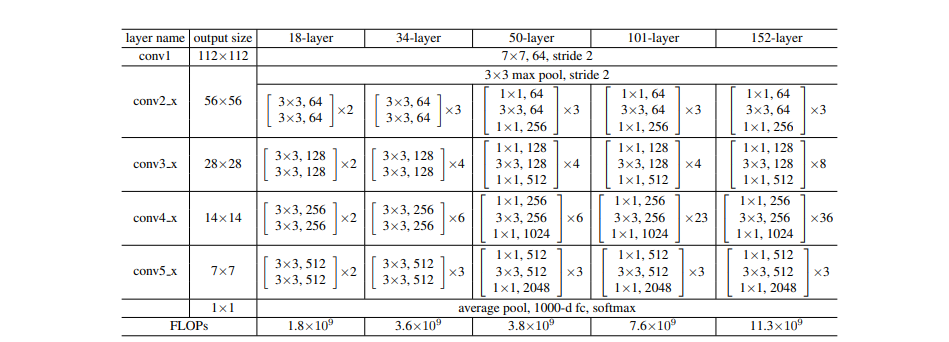

In [17]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels) 
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        x1 = self.relu1(self.bn1(self.conv1(x)))
        residual = self.bn2(self.conv2(x1))
        
        if self.conv3 is not None:
            x = self.conv3(x)
            
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f"block_{i}_{j}", ResNetBlock2(in_channels, out_channels))
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [18]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [04:17<00:00,  6.06it/s]


Epoch 1 of 30 took 264.244s
  training loss (in-iteration): 	4.744251
  validation accuracy: 			7.92 %


100%|██████████| 1563/1563 [04:11<00:00,  6.21it/s]


Epoch 2 of 30 took 257.907s
  training loss (in-iteration): 	4.160254
  validation accuracy: 			13.42 %


100%|██████████| 1563/1563 [04:12<00:00,  6.19it/s]


Epoch 3 of 30 took 258.993s
  training loss (in-iteration): 	3.836764
  validation accuracy: 			17.47 %


100%|██████████| 1563/1563 [04:12<00:00,  6.20it/s]


Epoch 4 of 30 took 258.734s
  training loss (in-iteration): 	3.606543
  validation accuracy: 			18.26 %


100%|██████████| 1563/1563 [04:10<00:00,  6.24it/s]


Epoch 5 of 30 took 256.784s
  training loss (in-iteration): 	3.422903
  validation accuracy: 			20.00 %


100%|██████████| 1563/1563 [04:11<00:00,  6.22it/s]


Epoch 6 of 30 took 257.690s
  training loss (in-iteration): 	3.268475
  validation accuracy: 			25.23 %


100%|██████████| 1563/1563 [04:12<00:00,  6.18it/s]


Epoch 7 of 30 took 259.414s
  training loss (in-iteration): 	3.139131
  validation accuracy: 			24.85 %


100%|██████████| 1563/1563 [04:11<00:00,  6.22it/s]


Epoch 8 of 30 took 257.776s
  training loss (in-iteration): 	3.029130
  validation accuracy: 			29.83 %


100%|██████████| 1563/1563 [04:09<00:00,  6.27it/s]


Epoch 9 of 30 took 255.738s
  training loss (in-iteration): 	2.927812
  validation accuracy: 			24.37 %


100%|██████████| 1563/1563 [04:07<00:00,  6.31it/s]


Epoch 10 of 30 took 254.121s
  training loss (in-iteration): 	2.844304
  validation accuracy: 			32.87 %


100%|██████████| 1563/1563 [04:08<00:00,  6.29it/s]


Epoch 11 of 30 took 254.980s
  training loss (in-iteration): 	2.768723
  validation accuracy: 			32.55 %


100%|██████████| 1563/1563 [04:08<00:00,  6.29it/s]


Epoch 12 of 30 took 254.704s
  training loss (in-iteration): 	2.701946
  validation accuracy: 			33.88 %


100%|██████████| 1563/1563 [04:08<00:00,  6.30it/s]


Epoch 13 of 30 took 254.440s
  training loss (in-iteration): 	2.633623
  validation accuracy: 			36.16 %


100%|██████████| 1563/1563 [04:09<00:00,  6.27it/s]


Epoch 14 of 30 took 255.609s
  training loss (in-iteration): 	2.580674
  validation accuracy: 			37.17 %


100%|██████████| 1563/1563 [04:07<00:00,  6.30it/s]


Epoch 15 of 30 took 254.281s
  training loss (in-iteration): 	2.521304
  validation accuracy: 			36.19 %


100%|██████████| 1563/1563 [04:10<00:00,  6.23it/s]


Epoch 16 of 30 took 257.323s
  training loss (in-iteration): 	2.474780
  validation accuracy: 			39.27 %


100%|██████████| 1563/1563 [04:09<00:00,  6.27it/s]


Epoch 17 of 30 took 255.714s
  training loss (in-iteration): 	2.429492
  validation accuracy: 			39.03 %


100%|██████████| 1563/1563 [04:11<00:00,  6.22it/s]


Epoch 18 of 30 took 257.783s
  training loss (in-iteration): 	2.391295
  validation accuracy: 			40.74 %


100%|██████████| 1563/1563 [04:09<00:00,  6.26it/s]


Epoch 19 of 30 took 255.865s
  training loss (in-iteration): 	2.347966
  validation accuracy: 			40.64 %


100%|██████████| 1563/1563 [04:11<00:00,  6.22it/s]


Epoch 20 of 30 took 257.867s
  training loss (in-iteration): 	2.313958
  validation accuracy: 			41.07 %


100%|██████████| 1563/1563 [04:08<00:00,  6.29it/s]


Epoch 21 of 30 took 255.187s
  training loss (in-iteration): 	2.275585
  validation accuracy: 			40.68 %


100%|██████████| 1563/1563 [04:08<00:00,  6.28it/s]


Epoch 22 of 30 took 255.379s
  training loss (in-iteration): 	2.242198
  validation accuracy: 			40.50 %


100%|██████████| 1563/1563 [04:07<00:00,  6.32it/s]


Epoch 23 of 30 took 253.845s
  training loss (in-iteration): 	2.212138
  validation accuracy: 			42.41 %


100%|██████████| 1563/1563 [04:04<00:00,  6.38it/s]


Epoch 24 of 30 took 251.307s
  training loss (in-iteration): 	2.183040
  validation accuracy: 			42.12 %


100%|██████████| 1563/1563 [04:16<00:00,  6.09it/s]


Epoch 25 of 30 took 263.052s
  training loss (in-iteration): 	2.156438
  validation accuracy: 			42.66 %


100%|██████████| 1563/1563 [04:15<00:00,  6.12it/s]


Epoch 26 of 30 took 261.559s
  training loss (in-iteration): 	2.126360
  validation accuracy: 			42.80 %


100%|██████████| 1563/1563 [04:14<00:00,  6.14it/s]


Epoch 27 of 30 took 261.117s
  training loss (in-iteration): 	2.105006
  validation accuracy: 			41.88 %


100%|██████████| 1563/1563 [04:14<00:00,  6.13it/s]


Epoch 28 of 30 took 261.173s
  training loss (in-iteration): 	2.076761
  validation accuracy: 			43.42 %


100%|██████████| 1563/1563 [04:15<00:00,  6.12it/s]


Epoch 29 of 30 took 261.903s
  training loss (in-iteration): 	2.054353
  validation accuracy: 			44.18 %


100%|██████████| 1563/1563 [04:15<00:00,  6.11it/s]


Epoch 30 of 30 took 262.111s
  training loss (in-iteration): 	2.030008
  validation accuracy: 			45.16 %


In [19]:
torch.save(model.state_dict(), "resnet_state.pt")

If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [18]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 782/782 [03:43<00:00,  3.49it/s]


Epoch 1 of 30 took 225.628s
  training loss (in-iteration): 	4.578845
  validation accuracy: 			8.32 %


100%|██████████| 782/782 [03:29<00:00,  3.73it/s]


Epoch 2 of 30 took 211.767s
  training loss (in-iteration): 	4.062108
  validation accuracy: 			10.99 %


100%|██████████| 782/782 [03:30<00:00,  3.72it/s]


Epoch 3 of 30 took 212.178s
  training loss (in-iteration): 	3.741271
  validation accuracy: 			16.53 %


100%|██████████| 782/782 [03:29<00:00,  3.73it/s]


Epoch 4 of 30 took 211.660s
  training loss (in-iteration): 	3.506000
  validation accuracy: 			18.62 %


100%|██████████| 782/782 [03:30<00:00,  3.72it/s]


Epoch 5 of 30 took 212.054s
  training loss (in-iteration): 	3.319717
  validation accuracy: 			23.38 %


100%|██████████| 782/782 [03:28<00:00,  3.76it/s]


Epoch 6 of 30 took 209.923s
  training loss (in-iteration): 	3.166823
  validation accuracy: 			23.42 %


100%|██████████| 782/782 [03:29<00:00,  3.73it/s]


Epoch 7 of 30 took 211.876s
  training loss (in-iteration): 	3.039751
  validation accuracy: 			27.30 %


100%|██████████| 782/782 [03:28<00:00,  3.75it/s]


Epoch 8 of 30 took 210.397s
  training loss (in-iteration): 	2.928894
  validation accuracy: 			28.53 %


100%|██████████| 782/782 [03:27<00:00,  3.76it/s]


Epoch 9 of 30 took 209.548s
  training loss (in-iteration): 	2.822303
  validation accuracy: 			31.09 %


100%|██████████| 782/782 [03:29<00:00,  3.73it/s]


Epoch 10 of 30 took 211.768s
  training loss (in-iteration): 	2.735117
  validation accuracy: 			31.31 %


100%|██████████| 782/782 [03:28<00:00,  3.76it/s]


Epoch 11 of 30 took 210.537s
  training loss (in-iteration): 	2.652798
  validation accuracy: 			33.40 %


100%|██████████| 782/782 [03:27<00:00,  3.78it/s]


Epoch 12 of 30 took 208.744s
  training loss (in-iteration): 	2.575663
  validation accuracy: 			33.58 %


100%|██████████| 782/782 [03:28<00:00,  3.74it/s]


Epoch 13 of 30 took 210.608s
  training loss (in-iteration): 	2.505373
  validation accuracy: 			34.46 %


100%|██████████| 782/782 [03:26<00:00,  3.78it/s]


Epoch 14 of 30 took 208.402s
  training loss (in-iteration): 	2.446676
  validation accuracy: 			35.23 %


100%|██████████| 782/782 [03:29<00:00,  3.74it/s]


Epoch 15 of 30 took 210.972s
  training loss (in-iteration): 	2.390225
  validation accuracy: 			36.29 %


100%|██████████| 782/782 [03:32<00:00,  3.68it/s]


Epoch 16 of 30 took 214.061s
  training loss (in-iteration): 	2.337866
  validation accuracy: 			36.38 %


100%|██████████| 782/782 [03:30<00:00,  3.72it/s]


Epoch 17 of 30 took 211.762s
  training loss (in-iteration): 	2.284136
  validation accuracy: 			37.03 %


100%|██████████| 782/782 [03:30<00:00,  3.71it/s]


Epoch 18 of 30 took 212.442s
  training loss (in-iteration): 	2.238071
  validation accuracy: 			38.06 %


100%|██████████| 782/782 [03:31<00:00,  3.70it/s]


Epoch 19 of 30 took 212.902s
  training loss (in-iteration): 	2.199109
  validation accuracy: 			38.16 %


100%|██████████| 782/782 [03:30<00:00,  3.71it/s]


Epoch 20 of 30 took 212.371s
  training loss (in-iteration): 	2.155547
  validation accuracy: 			38.90 %


100%|██████████| 782/782 [03:29<00:00,  3.73it/s]


Epoch 21 of 30 took 211.584s
  training loss (in-iteration): 	2.116473
  validation accuracy: 			40.24 %


100%|██████████| 782/782 [03:28<00:00,  3.76it/s]


Epoch 22 of 30 took 209.847s
  training loss (in-iteration): 	2.070928
  validation accuracy: 			40.07 %


100%|██████████| 782/782 [03:25<00:00,  3.81it/s]


Epoch 23 of 30 took 207.028s
  training loss (in-iteration): 	2.042809
  validation accuracy: 			40.10 %


100%|██████████| 782/782 [03:39<00:00,  3.56it/s]


Epoch 24 of 30 took 221.743s
  training loss (in-iteration): 	2.003706
  validation accuracy: 			40.97 %


100%|██████████| 782/782 [03:42<00:00,  3.52it/s]


Epoch 25 of 30 took 224.240s
  training loss (in-iteration): 	1.964865
  validation accuracy: 			40.32 %


100%|██████████| 782/782 [03:36<00:00,  3.61it/s]


Epoch 26 of 30 took 218.682s
  training loss (in-iteration): 	1.938165
  validation accuracy: 			40.76 %


100%|██████████| 782/782 [03:36<00:00,  3.61it/s]


Epoch 27 of 30 took 218.237s
  training loss (in-iteration): 	1.910019
  validation accuracy: 			41.15 %


100%|██████████| 782/782 [03:33<00:00,  3.66it/s]


Epoch 28 of 30 took 215.610s
  training loss (in-iteration): 	1.879627
  validation accuracy: 			41.30 %


100%|██████████| 782/782 [03:35<00:00,  3.62it/s]


Epoch 29 of 30 took 218.081s
  training loss (in-iteration): 	1.852048
  validation accuracy: 			41.44 %


100%|██████████| 782/782 [03:39<00:00,  3.57it/s]


Epoch 30 of 30 took 221.088s
  training loss (in-iteration): 	1.819834
  validation accuracy: 			41.92 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [19]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.41920490506329117


In [54]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for i in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch_transformed = transformations(X_batch)
                #print(X_batch_transformed.shape)
                logits = model(X_batch_transformed.to(device))
                
                logits_per_transform.append(logits)
                
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.stack(logits_per_transform, dim = 0).mean(axis = 0)
            #print(logits_per_transform[0].shape, averaged_logits.shape)
            y_pred = averaged_logits.max(dim=1)[1].data
            #print(y_pred.shape)
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [55]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
    transforms.ColorJitter(brightness=.1, hue=.1, saturation=0.1),
])

In [56]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 79/79 [00:48<00:00,  1.64it/s]


Model accuracy with 3 forward runs is 0.42503955696202533


100%|██████████| 79/79 [01:13<00:00,  1.08it/s]


Model accuracy with 5 forward runs is 0.4248417721518987


100%|██████████| 79/79 [01:40<00:00,  1.28s/it]


Model accuracy with 7 forward runs is 0.4275118670886076


100%|██████████| 79/79 [02:10<00:00,  1.65s/it]


Model accuracy with 9 forward runs is 0.4272151898734177


100%|██████████| 79/79 [03:07<00:00,  2.38s/it]


Model accuracy with 13 forward runs is 0.4305775316455696


100%|██████████| 79/79 [03:29<00:00,  2.66s/it]

Model accuracy with 15 forward runs is 0.4296875


Let's visualize what we have computed

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

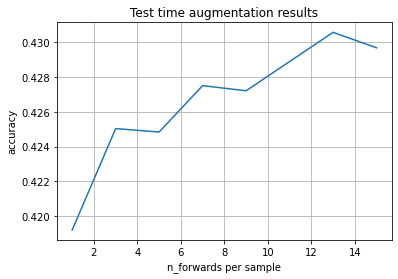

In [58]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape